ANOVA-Tabelle (ohne Sport):
                       sum_sq     df         F    PR(>F)
C(Autor)            11.043089    1.0  7.796708  0.006251
C(Thema)            15.026749    2.0  5.304638  0.006432
C(Autor):C(Thema)    0.690027    2.0  0.243588  0.784265
Residual           144.470588  102.0       NaN       NaN


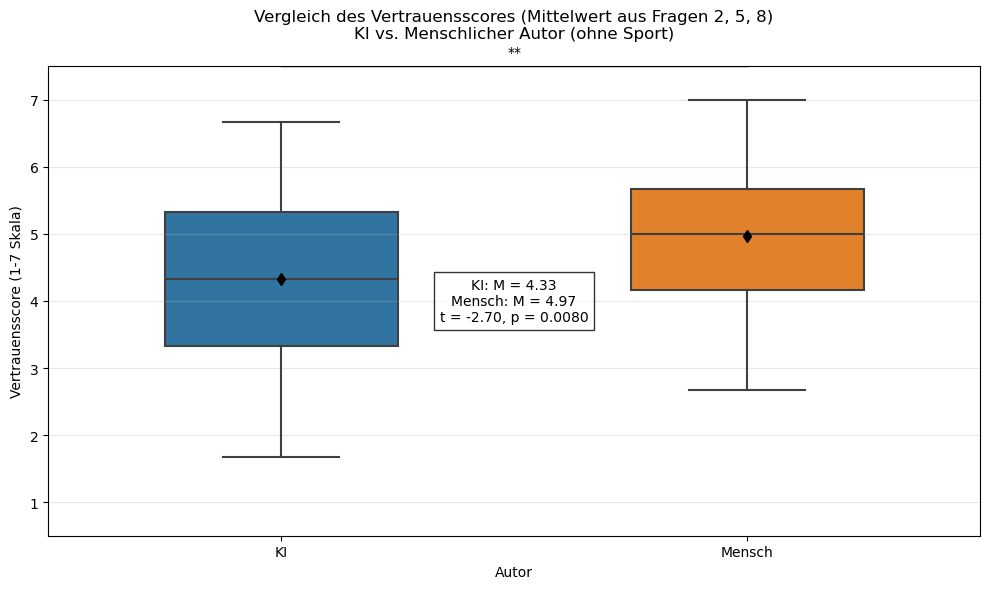

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols

# 1. Daten laden und vorbereiten
ai_data = pd.read_csv('ai_labelled.csv')
human_data = pd.read_csv('human_labelled.csv', sep=';')
ai_data['Autor'] = 'KI'
human_data['Autor'] = 'Mensch'
data = pd.concat([ai_data, human_data])

# 2. Mittelwert aus Fragen 2, 5, 8 berechnen (ohne Sport)
def calculate_mean_score(row, topic):
    q2 = row[f'{topic} - 2. Wie glaubwürdig fanden Sie den Text ?']
    q5 = row[f'{topic} - 5. Wie viel Vertrauen haben Sie in den Inhalt des Textes?']
    q8 = row[f'{topic} - 8. Wie sehr vertrauen Sie den im Text präsentierten Informationen?']
    return np.mean([q2, q5, q8])

# Daten umwandeln (nur Geld, Gesundheit, Wissen)
melted_data = pd.DataFrame()
for topic in ['Geld', 'Gesundheit', 'Wissen']:  # Sport entfernt
    temp_df = data[['Autor']].copy()
    temp_df['Thema'] = topic
    temp_df['Vertrauensscore'] = data.apply(lambda row: calculate_mean_score(row, topic), axis=1)
    melted_data = pd.concat([melted_data, temp_df])

# 3. ANOVA durchführen
model = ols('Vertrauensscore ~ C(Autor) + C(Thema) + C(Autor):C(Thema)', data=melted_data).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print("ANOVA-Tabelle (ohne Sport):")
print(anova_table)

# 4. Vergleichsdiagramm erstellen
plt.figure(figsize=(10, 6))

# Boxplot mit Signifikanzmarkierung
ax = sns.boxplot(x='Autor', y='Vertrauensscore', data=melted_data, 
                 palette={'KI': '#1f77b4', 'Mensch': '#ff7f0e'},
                 width=0.5, showmeans=True,
                 meanprops={"marker":"d", "markerfacecolor":"black", "markeredgecolor":"black"})

# t-Test und Signifikanzmarkierung
ki_values = melted_data[melted_data['Autor'] == 'KI']['Vertrauensscore']
human_values = melted_data[melted_data['Autor'] == 'Mensch']['Vertrauensscore']
t_stat, p_val = stats.ttest_ind(ki_values, human_values)

# Signifikanzsterne hinzufügen
y_max = melted_data['Vertrauensscore'].max() + 0.5
if p_val < 0.001:
    sig_symbol = '***'
elif p_val < 0.01:
    sig_symbol = '**'
elif p_val < 0.05:
    sig_symbol = '*'
else:
    sig_symbol = 'n.s.'

plt.plot([0, 1], [y_max, y_max], color='black', lw=1)
plt.text(0.5, y_max+0.1, sig_symbol, ha='center', va='bottom', color='black')

# Diagramm beschriften
plt.grid(axis='y', alpha=0.3)
plt.title('Vergleich des Vertrauensscores (Mittelwert aus Fragen 2, 5, 8)\nKI vs. Menschlicher Autor (ohne Sport)', pad=20)
plt.xlabel('Autor')
plt.ylabel('Vertrauensscore (1-7 Skala)')
plt.ylim(0.5, 7.5)


# Deskriptive Statistiken anzeigen
ki_mean = np.mean(ki_values)
human_mean = np.mean(human_values)
plt.text(0.5, 0.5, 
         f"KI: M = {ki_mean:.2f}\nMensch: M = {human_mean:.2f}\nt = {t_stat:.2f}, p = {p_val:.4f}",
         ha='center', va='center', transform=ax.transAxes,
         bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

=== Statistische Tests für Vertrauensindex ===
t-Tests (KI vs. Mensch pro Thema):
Geld: t = -1.15, p = 0.2590 | KI: M = 4.58 | Mensch: M = 5.04
Gesundheit: t = -1.69, p = 0.1006 | KI: M = 4.70 | Mensch: M = 5.31
Wissen: t = -2.04, p = 0.0493 | KI: M = 3.72 | Mensch: M = 4.57

ANOVA (Themenunterschiede pro Autor):
KI-Autoren: F = 3.33, p = 0.0432
Mensch-Autoren: F = 2.06, p = 0.1386

Deskriptive Statistiken:
                   count      mean       std       min       25%       50%  \
Autor  Thema                                                                 
KI     Geld         19.0  4.578947  1.275806  2.333333  3.333333  5.000000   
       Gesundheit   19.0  4.701754  1.309485  1.666667  4.000000  4.333333   
       Wissen       19.0  3.719298  1.248521  1.666667  2.666667  3.666667   
Mensch Geld         17.0  5.039216  1.129665  2.666667  4.666667  5.000000   
       Gesundheit   17.0  5.313725  0.828910  4.000000  4.333333  5.666667   
       Wissen       17.0  4.568627  1.24590

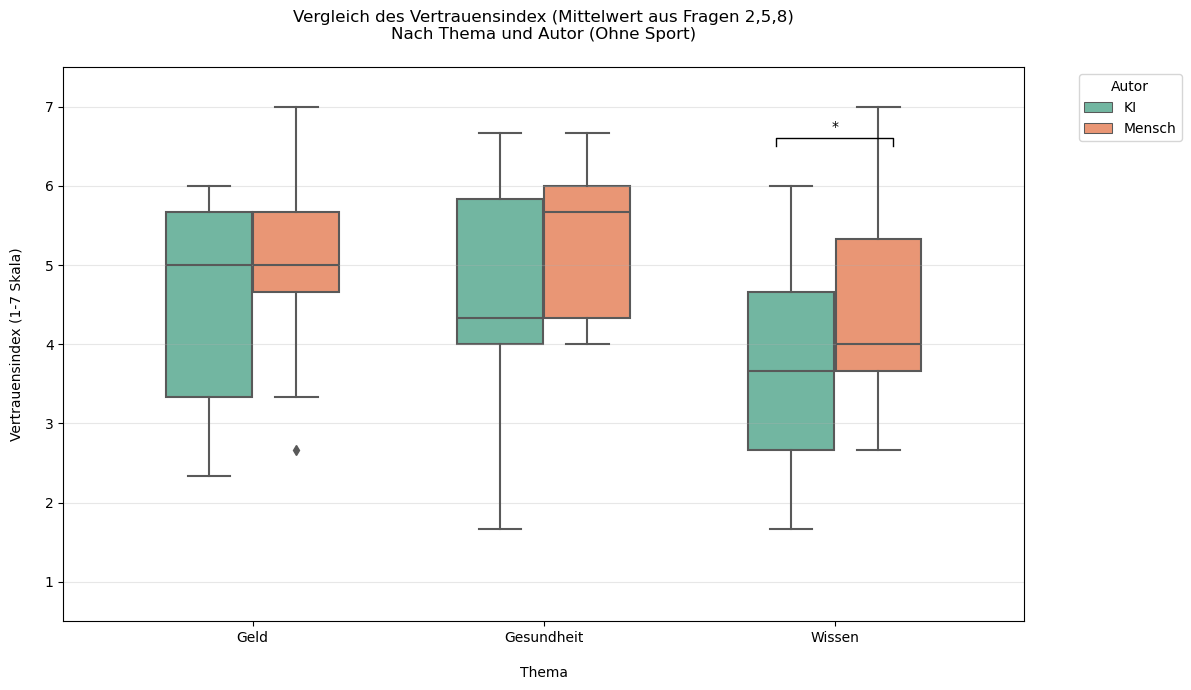

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np

# Daten laden und vorbereiten
ai_data = pd.read_csv('ai_labelled.csv')
human_data = pd.read_csv('human_labelled.csv', sep=';')
ai_data['Autor'] = 'KI'
human_data['Autor'] = 'Mensch'
data = pd.concat([ai_data, human_data])

# Funktion zur Berechnung des Vertrauensindex (Fragen 2,5,8)
def calculate_trust_index(row, topic):
    q2 = row[f'{topic} - 2. Wie glaubwürdig fanden Sie den Text ?']
    q5 = row[f'{topic} - 5. Wie viel Vertrauen haben Sie in den Inhalt des Textes?']
    q8 = row[f'{topic} - 8. Wie sehr vertrauen Sie den im Text präsentierten Informationen?']
    return np.mean([q2, q5, q8])

# Vertrauensindex für alle Themen (ohne Sport) berechnen
trust_data = pd.DataFrame()
for topic in ['Geld', 'Gesundheit', 'Wissen']:  # Sport explizit ausgeschlossen
    temp_df = data[['Autor']].copy()
    temp_df['Thema'] = topic
    temp_df['Vertrauensindex'] = data.apply(lambda row: calculate_trust_index(row, topic), axis=1)
    trust_data = pd.concat([trust_data, temp_df])

# Boxplot mit statistischen Tests
plt.figure(figsize=(12, 7))
sns.boxplot(x='Thema', y='Vertrauensindex', hue='Autor', 
           data=trust_data, palette='Set2', width=0.6,
           order=['Geld', 'Gesundheit', 'Wissen'])
plt.title('Vergleich des Vertrauensindex (Mittelwert aus Fragen 2,5,8)\nNach Thema und Autor (Ohne Sport)', pad=20)
plt.xlabel('Thema', labelpad=15)
plt.ylabel('Vertrauensindex (1-7 Skala)', labelpad=15)
plt.ylim(0.5, 7.5)
plt.legend(title='Autor', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', alpha=0.3)

# Signifikanzmarkierung
def annotate_significance(x1, x2, y, p):
    if p < 0.001:
        symbol = '***'
    elif p < 0.01:
        symbol = '**'
    elif p < 0.05:
        symbol = '*'
    else:
        return
    plt.plot([x1, x1, x2, x2], [y, y+0.1, y+0.1, y], lw=1, color='black')
    plt.text((x1+x2)*0.5, y+0.15, symbol, ha='center', va='bottom', color='black')

# t-Tests pro Thema (KI vs. Mensch)
y_pos = 6.5
themen = ['Geld', 'Gesundheit', 'Wissen']
print("=== Statistische Tests für Vertrauensindex ===")
print("t-Tests (KI vs. Mensch pro Thema):")
for i, thema in enumerate(themen):
    ki = trust_data[(trust_data['Autor'] == 'KI') & (trust_data['Thema'] == thema)]['Vertrauensindex']
    mensch = trust_data[(trust_data['Autor'] == 'Mensch') & (trust_data['Thema'] == thema)]['Vertrauensindex']
    
    t_stat, p_val = stats.ttest_ind(ki, mensch, nan_policy='omit', equal_var=False)
    print(f"{thema}: t = {t_stat:.2f}, p = {p_val:.4f} | KI: M = {np.mean(ki):.2f} | Mensch: M = {np.mean(mensch):.2f}")
    annotate_significance(i-0.2, i+0.2, y_pos, p_val)

# ANOVA für Themenunterschiede (getrennt nach Autor)
print("\nANOVA (Themenunterschiede pro Autor):")
for autor in ['KI', 'Mensch']:
    autor_data = trust_data[trust_data['Autor'] == autor]
    groups = [autor_data[autor_data['Thema'] == t]['Vertrauensindex'] for t in themen]
    f_stat, p_val = stats.f_oneway(*groups)
    print(f"{autor}-Autoren: F = {f_stat:.2f}, p = {p_val:.4f}")

# Deskriptive Statistiken
print("\nDeskriptive Statistiken:")
print(trust_data.groupby(['Autor', 'Thema'])['Vertrauensindex'].describe())

plt.tight_layout()
plt.show()

Deskriptive Statistiken:
            count      mean       std       min       25%  50%       75%  \
Thema                                                                      
Geld         36.0  4.796296  1.214405  2.333333  3.916667  5.0  5.666667   
Gesundheit   36.0  4.990741  1.136651  1.666667  4.333333  5.0  6.000000   
Wissen       36.0  4.120370  1.302386  1.666667  3.333333  4.0  5.000000   

                 max  
Thema                 
Geld        7.000000  
Gesundheit  6.666667  
Wissen      7.000000  

ANOVA: F = 5.05, p = 0.0080

Tukey HSD Post-hoc Tests:
    Multiple Comparison of Means - Tukey HSD, FWER=0.05     
  group1     group2   meandiff p-adj   lower   upper  reject
------------------------------------------------------------
      Geld Gesundheit   0.1944 0.7777  -0.489  0.8779  False
      Geld     Wissen  -0.6759 0.0533 -1.3594  0.0075  False
Gesundheit     Wissen  -0.8704 0.0086 -1.5538 -0.1869   True
---------------------------------------------------------

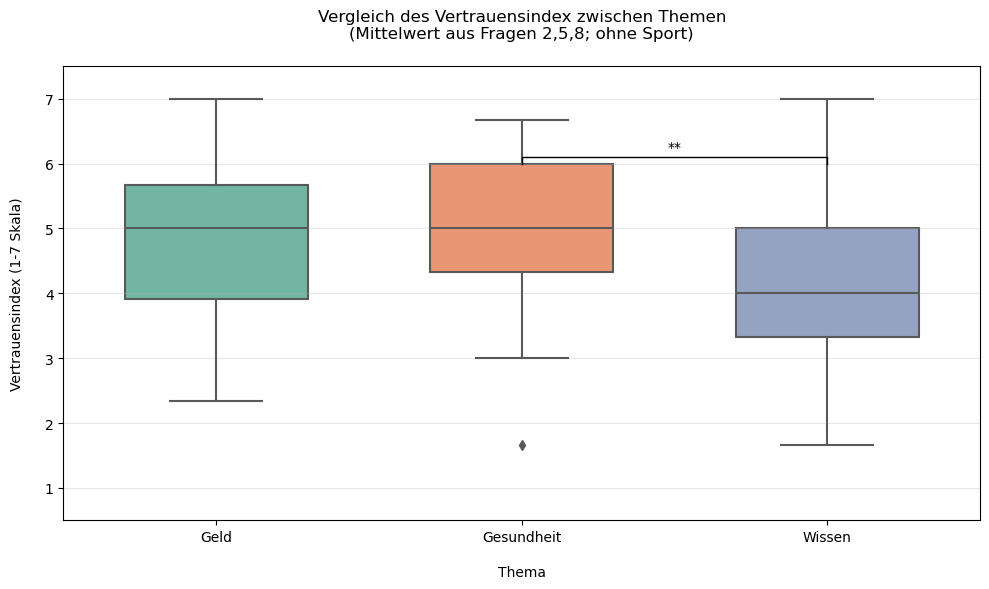

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Daten laden und vorbereiten
ai_data = pd.read_csv('ai_labelled.csv')
human_data = pd.read_csv('human_labelled.csv', sep=';')
data = pd.concat([ai_data, human_data])

# Funktion zur Berechnung des Vertrauensindex
def calculate_trust_index(row, topic):
    q2 = row[f'{topic} - 2. Wie glaubwürdig fanden Sie den Text ?']
    q5 = row[f'{topic} - 5. Wie viel Vertrauen haben Sie in den Inhalt des Textes?']
    q8 = row[f'{topic} - 8. Wie sehr vertrauen Sie den im Text präsentierten Informationen?']
    return np.mean([q2, q5, q8])

# Daten für Vertrauensindex vorbereiten (ohne Sport)
trust_data = pd.DataFrame()
for topic in ['Geld', 'Gesundheit', 'Wissen']:
    temp_df = data[[]].copy()
    temp_df['Thema'] = topic
    temp_df['Vertrauensindex'] = data.apply(lambda row: calculate_trust_index(row, topic), axis=1)
    trust_data = pd.concat([trust_data, temp_df])

# Deskriptive Statistiken
print("Deskriptive Statistiken:")
print(trust_data.groupby('Thema')['Vertrauensindex'].describe())

# ANOVA durchführen
groups = [trust_data[trust_data['Thema'] == t]['Vertrauensindex'] for t in ['Geld', 'Gesundheit', 'Wissen']]
f_stat, p_val = stats.f_oneway(*groups)
print(f"\nANOVA: F = {f_stat:.2f}, p = {p_val:.4f}")

# Post-hoc Tests (wenn ANOVA signifikant)
if p_val < 0.05:
    print("\nTukey HSD Post-hoc Tests:")
    tukey = pairwise_tukeyhsd(trust_data['Vertrauensindex'], trust_data['Thema'])
    print(tukey)

# Boxplot erstellen
plt.figure(figsize=(10, 6))
ax = sns.boxplot(x='Thema', y='Vertrauensindex', data=trust_data, 
                palette='Set2', width=0.6,
                order=['Geld', 'Gesundheit', 'Wissen'])
plt.title('Vergleich des Vertrauensindex zwischen Themen\n(Mittelwert aus Fragen 2,5,8; ohne Sport)', pad=20)
plt.xlabel('Thema', labelpad=15)
plt.ylabel('Vertrauensindex (1-7 Skala)', labelpad=15)
plt.ylim(0.5, 7.5)

# Signifikanzmarkierungen hinzufügen (wenn ANOVA signifikant)
if p_val < 0.05:
    # Ergebnisse des Tukey-Tests extrahieren
    results = pd.DataFrame(data=tukey._results_table.data[1:], 
                         columns=tukey._results_table.data[0])
    
    # Signifikante Vergleiche finden
    comparisons = [('Geld', 'Gesundheit'), ('Geld', 'Wissen'), ('Gesundheit', 'Wissen')]
    y_pos = 6.0
    y_offset = 0.4
    
    for comp in comparisons:
        group1, group2 = comp
        # Finde das Ergebnis im Tukey-Test
        result = results[((results.group1 == group1) & (results.group2 == group2)) | 
                        ((results.group1 == group2) & (results.group2 == group1))]
        if not result.empty and result['reject'].iloc[0]:
            p_val = result['p-adj'].iloc[0]
            x1 = ['Geld', 'Gesundheit', 'Wissen'].index(group1)
            x2 = ['Geld', 'Gesundheit', 'Wissen'].index(group2)
            
            # Signifikanzsterne bestimmen
            if p_val < 0.001:
                symbol = '***'
            elif p_val < 0.01:
                symbol = '**'
            elif p_val < 0.05:
                symbol = '*'
            
            # Linie und Text zeichnen
            plt.plot([x1, x1, x2, x2], [y_pos, y_pos+0.1, y_pos+0.1, y_pos], lw=1, color='black')
            plt.text((x1+x2)*0.5, y_pos+0.15, symbol, ha='center', va='bottom', color='black')
            y_pos += y_offset

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


--- Ergebnisse für Frage 1 (Wie viel Vorwissen haben sie zu dem Thema des Textes?) ---
t-Tests (KI vs. Mensch):
Geld: t = -0.98, p = 0.3344 | KI: M = 3.47±1.96 | Mensch: M = 4.12±1.87
Gesundheit: t = 0.76, p = 0.4523 | KI: M = 3.32±1.52 | Mensch: M = 2.94±1.35
Wissen: t = -1.05, p = 0.3004 | KI: M = 2.68±1.62 | Mensch: M = 3.29±1.74

ANOVA-Ergebnisse:
KI-Autoren: F = 1.07, p = 0.3493
Mensch-Autoren: F = 2.09, p = 0.1347


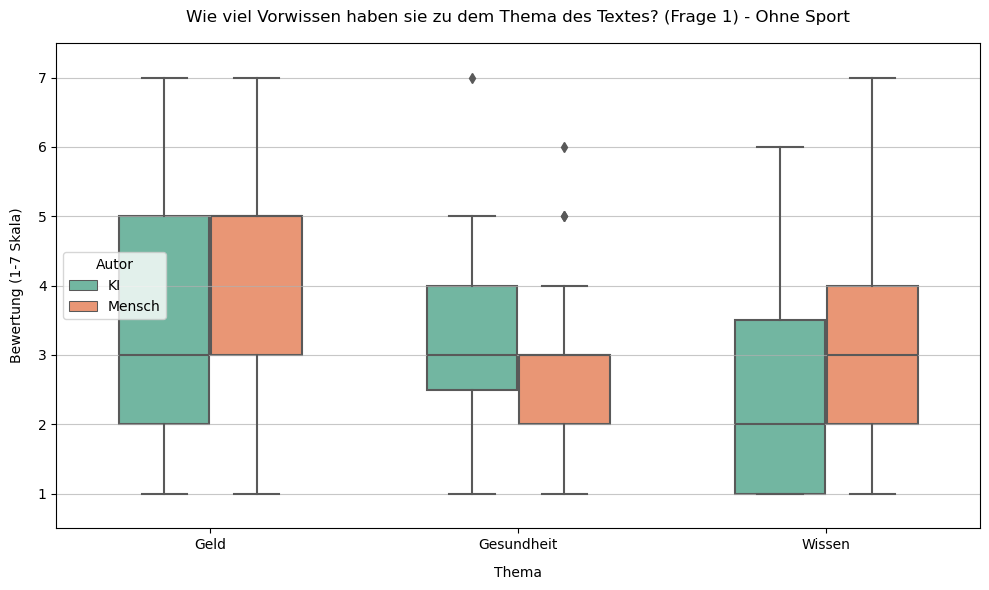


--- Ergebnisse für Frage 2 (Wie glaubwürdig fanden Sie den Text ?) ---
t-Tests (KI vs. Mensch):
Geld: t = -1.00, p = 0.3240 | KI: M = 4.95±1.05 | Mensch: M = 5.35±1.28
Gesundheit: t = -0.71, p = 0.4826 | KI: M = 5.26±1.21 | Mensch: M = 5.53±0.98
Wissen: t = -1.65, p = 0.1080 | KI: M = 4.26±1.21 | Mensch: M = 5.00±1.37

ANOVA-Ergebnisse:
KI-Autoren: F = 3.51, p = 0.0368
Mensch-Autoren: F = 0.78, p = 0.4646


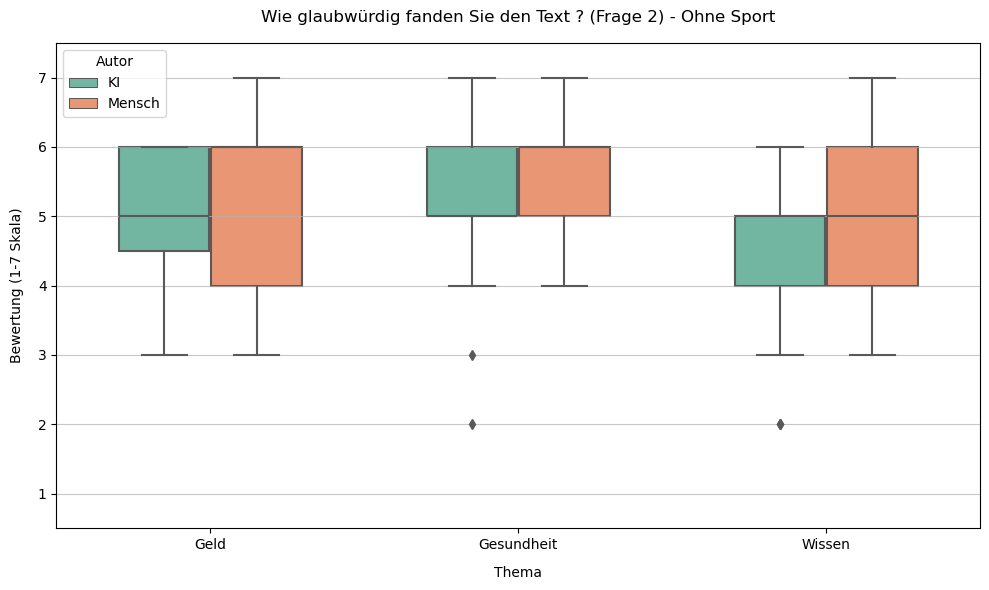


--- Ergebnisse für Frage 3 (Wie klar und verständlich war der Text?) ---
t-Tests (KI vs. Mensch):
Geld: t = -0.06, p = 0.9504 | KI: M = 4.79±1.20 | Mensch: M = 4.82±1.85
Gesundheit: t = -2.97, p = 0.0061 | KI: M = 5.53±1.19 | Mensch: M = 6.47±0.61
Wissen: t = -2.66, p = 0.0123 | KI: M = 4.63±0.93 | Mensch: M = 5.59±1.14

ANOVA-Ergebnisse:
KI-Autoren: F = 3.33, p = 0.0434
Mensch-Autoren: F = 6.38, p = 0.0035


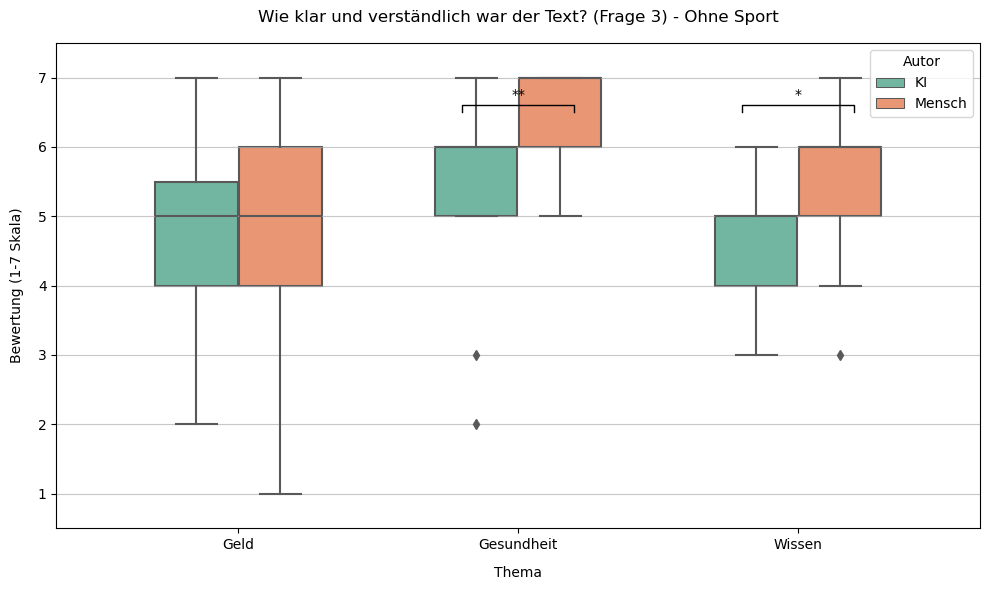


--- Ergebnisse für Frage 4 (Wie interessant fanden Sie den Text?) ---
t-Tests (KI vs. Mensch):
Geld: t = -0.15, p = 0.8794 | KI: M = 4.32±1.69 | Mensch: M = 4.41±1.94
Gesundheit: t = -0.34, p = 0.7376 | KI: M = 4.89±1.65 | Mensch: M = 5.06±1.16
Wissen: t = -0.49, p = 0.6309 | KI: M = 4.32±1.13 | Mensch: M = 4.59±1.97

ANOVA-Ergebnisse:
KI-Autoren: F = 0.88, p = 0.4199
Mensch-Autoren: F = 0.60, p = 0.5550


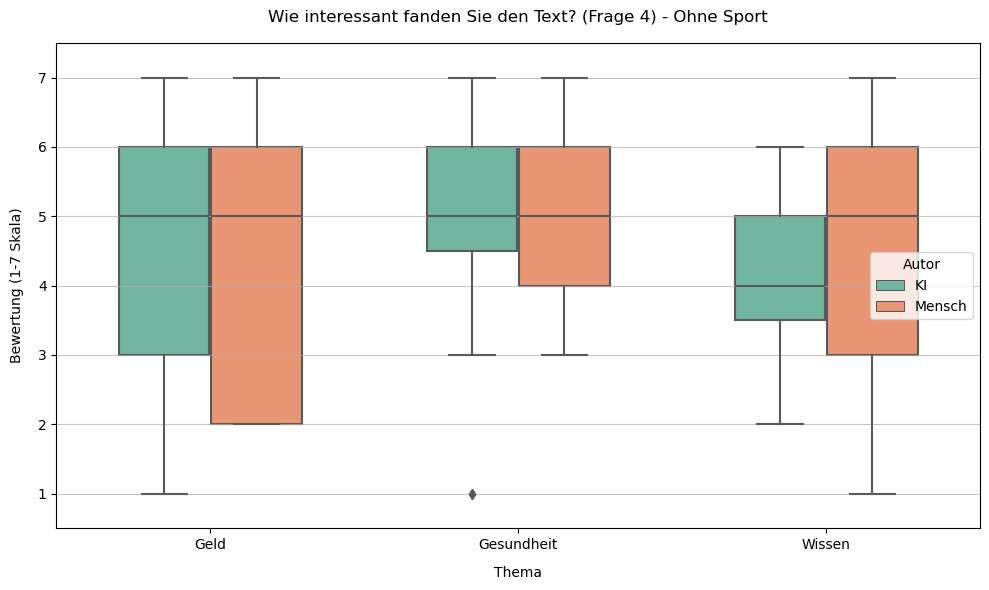


--- Ergebnisse für Frage 5 (Wie viel Vertrauen haben Sie in den Inhalt des Textes?) ---
t-Tests (KI vs. Mensch):
Geld: t = -0.67, p = 0.5103 | KI: M = 4.42±1.53 | Mensch: M = 4.76±1.48
Gesundheit: t = -1.32, p = 0.1969 | KI: M = 4.47±1.43 | Mensch: M = 5.06±1.16
Wissen: t = -2.16, p = 0.0383 | KI: M = 3.53±1.27 | Mensch: M = 4.53±1.42

ANOVA-Ergebnisse:
KI-Autoren: F = 2.55, p = 0.0875
Mensch-Autoren: F = 0.61, p = 0.5479


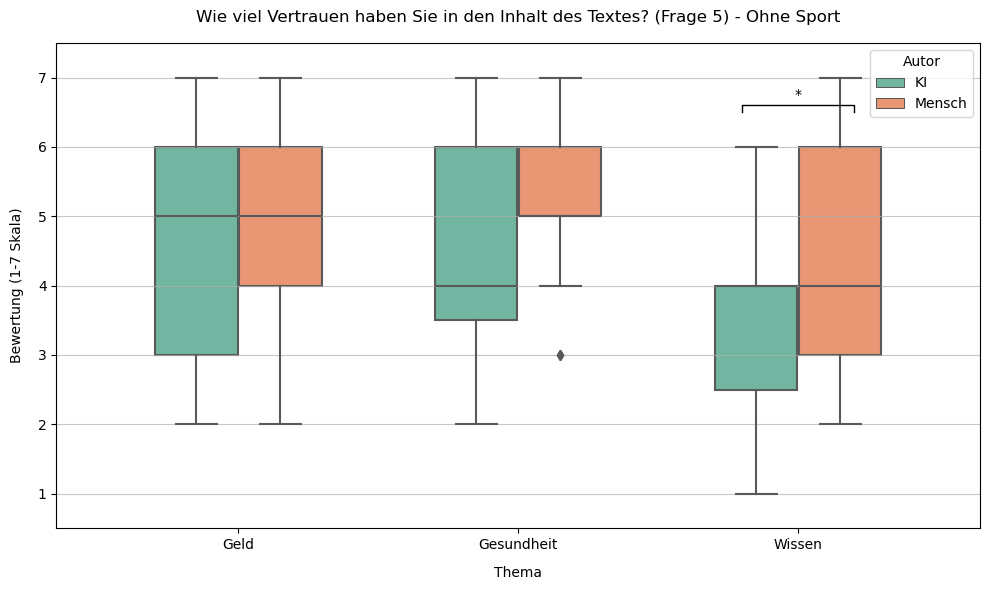


--- Ergebnisse für Frage 6 (Wie sachlich fanden sie den Text?) ---
t-Tests (KI vs. Mensch):
Geld: t = -0.80, p = 0.4293 | KI: M = 5.26±1.33 | Mensch: M = 5.59±1.03
Gesundheit: t = -0.89, p = 0.3780 | KI: M = 5.42±0.82 | Mensch: M = 5.71±1.02
Wissen: t = -0.97, p = 0.3395 | KI: M = 3.79±1.54 | Mensch: M = 4.35±1.81

ANOVA-Ergebnisse:
KI-Autoren: F = 9.08, p = 0.0004
Mensch-Autoren: F = 5.01, p = 0.0106


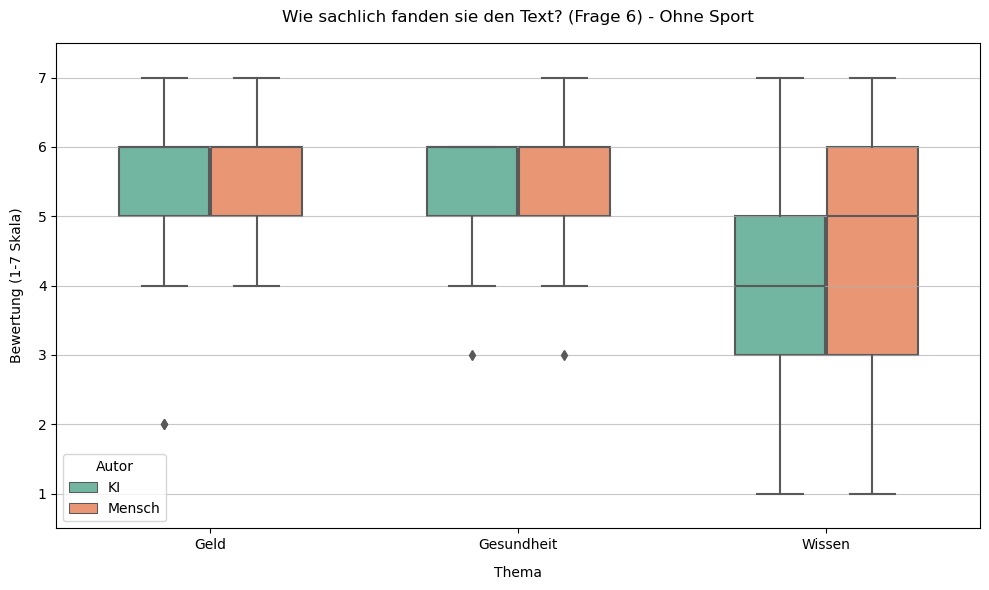


--- Ergebnisse für Frage 7 (Haben Sie den Eindruck, dass der Autor Fachkompetenz besitzt?) ---
t-Tests (KI vs. Mensch):
Geld: t = -0.87, p = 0.3901 | KI: M = 4.89±1.37 | Mensch: M = 5.24±0.88
Gesundheit: t = -0.87, p = 0.3915 | KI: M = 5.11±1.25 | Mensch: M = 5.41±0.77
Wissen: t = 0.08, p = 0.9368 | KI: M = 4.21±1.06 | Mensch: M = 4.18±1.38

ANOVA-Ergebnisse:
KI-Autoren: F = 2.59, p = 0.0844
Mensch-Autoren: F = 6.55, p = 0.0031


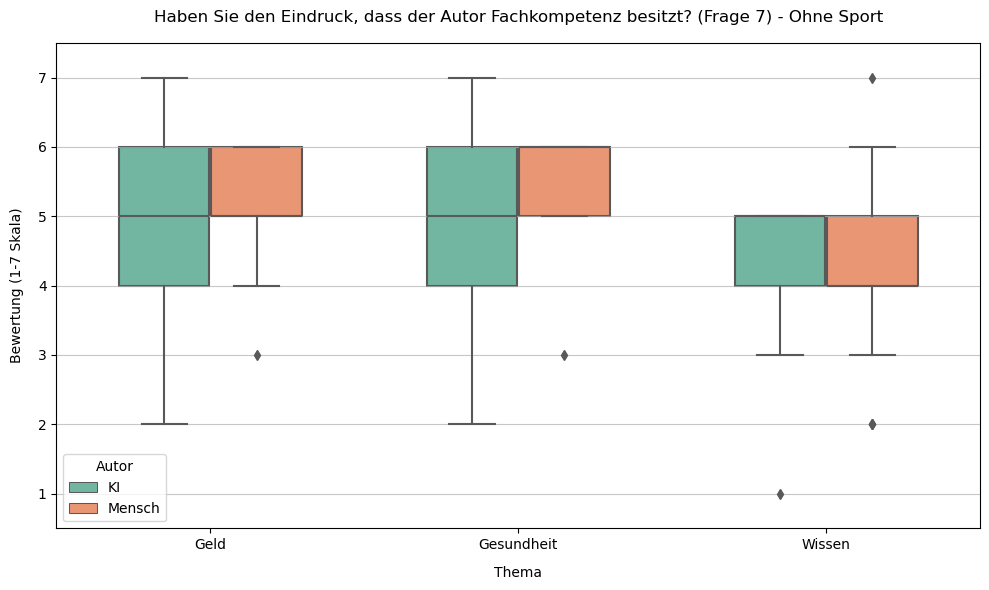


--- Ergebnisse für Frage 8 (Wie sehr vertrauen Sie den im Text präsentierten Informationen?) ---
t-Tests (KI vs. Mensch):
Geld: t = -1.37, p = 0.1809 | KI: M = 4.37±1.46 | Mensch: M = 5.00±1.24
Gesundheit: t = -2.31, p = 0.0277 | KI: M = 4.37±1.53 | Mensch: M = 5.35±0.90
Wissen: t = -1.59, p = 0.1211 | KI: M = 3.37±1.49 | Mensch: M = 4.18±1.46

ANOVA-Ergebnisse:
KI-Autoren: F = 2.69, p = 0.0772
Mensch-Autoren: F = 3.90, p = 0.0271


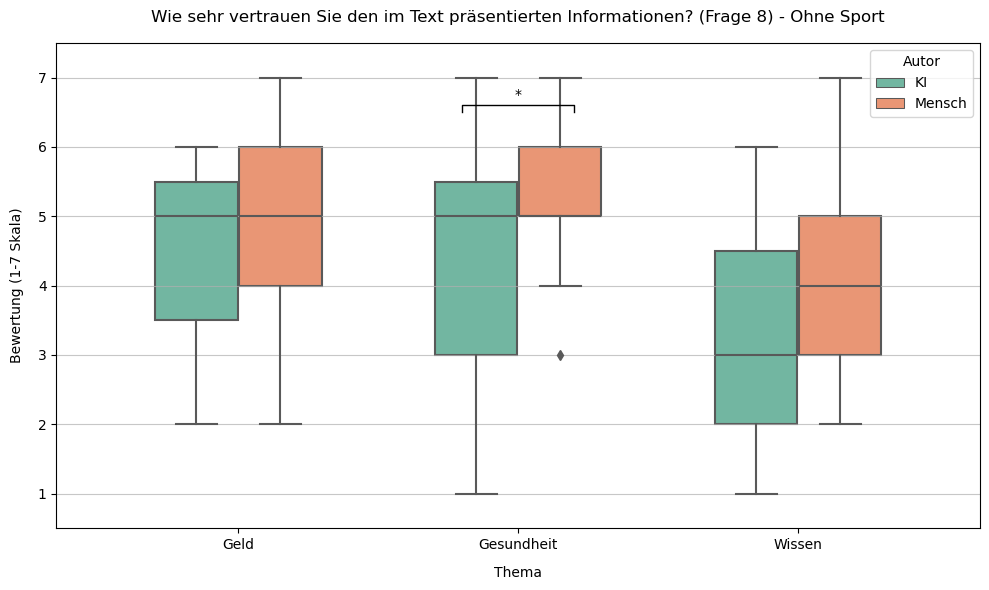


--- Ergebnisse für Frage 9 (Wie wahrscheinlich ist es, dass der Text missverstanden werden könnte?) ---
t-Tests (KI vs. Mensch):
Geld: t = -0.14, p = 0.8911 | KI: M = 3.05±1.28 | Mensch: M = 3.12±1.45
Gesundheit: t = 1.16, p = 0.2521 | KI: M = 2.74±1.02 | Mensch: M = 2.35±0.90
Wissen: t = 0.53, p = 0.6014 | KI: M = 3.37±1.49 | Mensch: M = 3.12±1.28

ANOVA-Ergebnisse:
KI-Autoren: F = 1.10, p = 0.3404
Mensch-Autoren: F = 2.05, p = 0.1393


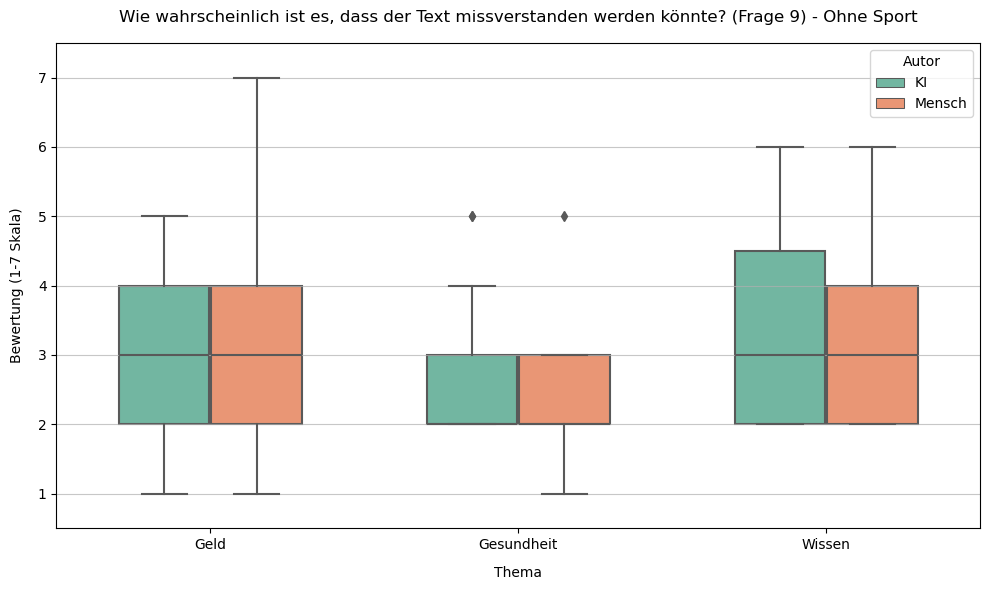


HINWEIS: Sport-Daten wurden in allen Analysen aufgrund eines identifizierten Textfehlers (falsche Spielerzuordnung) ausgeschlossen


In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np

# Daten laden und vorbereiten
ai_data = pd.read_csv('ai_labelled.csv')
human_data = pd.read_csv('human_labelled.csv', sep=';')
ai_data['Autor'] = 'KI'
human_data['Autor'] = 'Mensch'
data = pd.concat([ai_data, human_data])

# Fragenkatalog (ohne Frage 2, da bereits analysiert)
questions = {
    1: "Wie viel Vorwissen haben sie zu dem Thema des Textes?",
    2: "Wie glaubwürdig fanden Sie den Text ?",
    3: "Wie klar und verständlich war der Text?",
    4: "Wie interessant fanden Sie den Text?",
    5: "Wie viel Vertrauen haben Sie in den Inhalt des Textes?",
    6: "Wie sachlich fanden sie den Text?",
    7: "Haben Sie den Eindruck, dass der Autor Fachkompetenz besitzt?",
    8: "Wie sehr vertrauen Sie den im Text präsentierten Informationen?",
    9: "Wie wahrscheinlich ist es, dass der Text missverstanden werden könnte?"
}

# Analysefunktion (ohne Sport)
def analyze_question(question_num, question_text):
    # Daten extrahieren (Sport explizit ausschließen)
    melted_data = pd.melt(data, id_vars=['Autor'], 
                        value_vars=[
                            f'Geld - {question_num}. {question_text}',
                            f'Gesundheit - {question_num}. {question_text}',
                            f'Wissen - {question_num}. {question_text}'  # Kein Sport
                        ],
                        var_name='Frage', 
                        value_name='Bewertung')
    
    # Thema extrahieren
    melted_data['Thema'] = melted_data['Frage'].str.extract(r'(Geld|Gesundheit|Wissen)')
    
    # Boxplot erstellen
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Thema', y='Bewertung', hue='Autor', 
               data=melted_data, palette='Set2', width=0.6,
               order=['Geld', 'Gesundheit', 'Wissen'])
    plt.title(f'{question_text} (Frage {question_num}) - Ohne Sport', pad=15)
    plt.xlabel('Thema', labelpad=10)
    plt.ylabel('Bewertung (1-7 Skala)', labelpad=10)
    plt.ylim(0.5, 7.5)
    plt.legend(title='Autor')
    
    # Signifikanzmarkierung
    def annotate_significance(x1, x2, y, p):
        if p < 0.001:
            symbol = '***'
        elif p < 0.01:
            symbol = '**'
        elif p < 0.05:
            symbol = '*'
        else:
            return
        plt.plot([x1, x1, x2, x2], [y, y+0.1, y+0.1, y], lw=1, color='black')
        plt.text((x1+x2)*0.5, y+0.15, symbol, ha='center', va='bottom', color='black')
    
    # t-Tests pro Thema (KI vs. Mensch)
    y_pos = 6.5
    themen = ['Geld', 'Gesundheit', 'Wissen']
    print(f"\n--- Ergebnisse für Frage {question_num} ({question_text}) ---")
    print("t-Tests (KI vs. Mensch):")
    for i, thema in enumerate(themen):
        ki = melted_data[(melted_data['Autor'] == 'KI') & 
                        (melted_data['Thema'] == thema)]['Bewertung']
        mensch = melted_data[(melted_data['Autor'] == 'Mensch') & 
                            (melted_data['Thema'] == thema)]['Bewertung']
        
        # Welch's t-Test (ungleiche Varianzen annehmen)
        t_stat, p_val = stats.ttest_ind(ki, mensch, nan_policy='omit', equal_var=False)
        print(f"{thema}: t = {t_stat:.2f}, p = {p_val:.4f} | KI: M = {np.mean(ki):.2f}±{np.std(ki):.2f} | Mensch: M = {np.mean(mensch):.2f}±{np.std(mensch):.2f}")
        annotate_significance(i-0.2, i+0.2, y_pos, p_val)
    
    # ANOVA für Themenunterschiede (getrennt nach Autor)
    print("\nANOVA-Ergebnisse:")
    for autor in ['KI', 'Mensch']:
        autor_data = melted_data[melted_data['Autor'] == autor]
        groups = [autor_data[autor_data['Thema'] == t]['Bewertung'] for t in themen]
        f_stat, p_val = stats.f_oneway(*groups)
        print(f"{autor}-Autoren: F = {f_stat:.2f}, p = {p_val:.4f}")
    
    plt.tight_layout()
    plt.grid(axis='y', alpha=0.7)
    plt.show()

# Alle Fragen analysieren
for q_num, q_text in questions.items():
    analyze_question(q_num, q_text)

print("\nHINWEIS: Sport-Daten wurden in allen Analysen aufgrund eines identifizierten Textfehlers (falsche Spielerzuordnung) ausgeschlossen")

Durchschnittlicher Vertrauensindex (AI): 4.333333333333334
Durchschnittlicher Vertrauensindex (Mensch): 4.973856209150328

Korrelationsergebnisse:
AI: r = -0.038, p = 0.8785
Mensch: r = 0.083, p = 0.7506


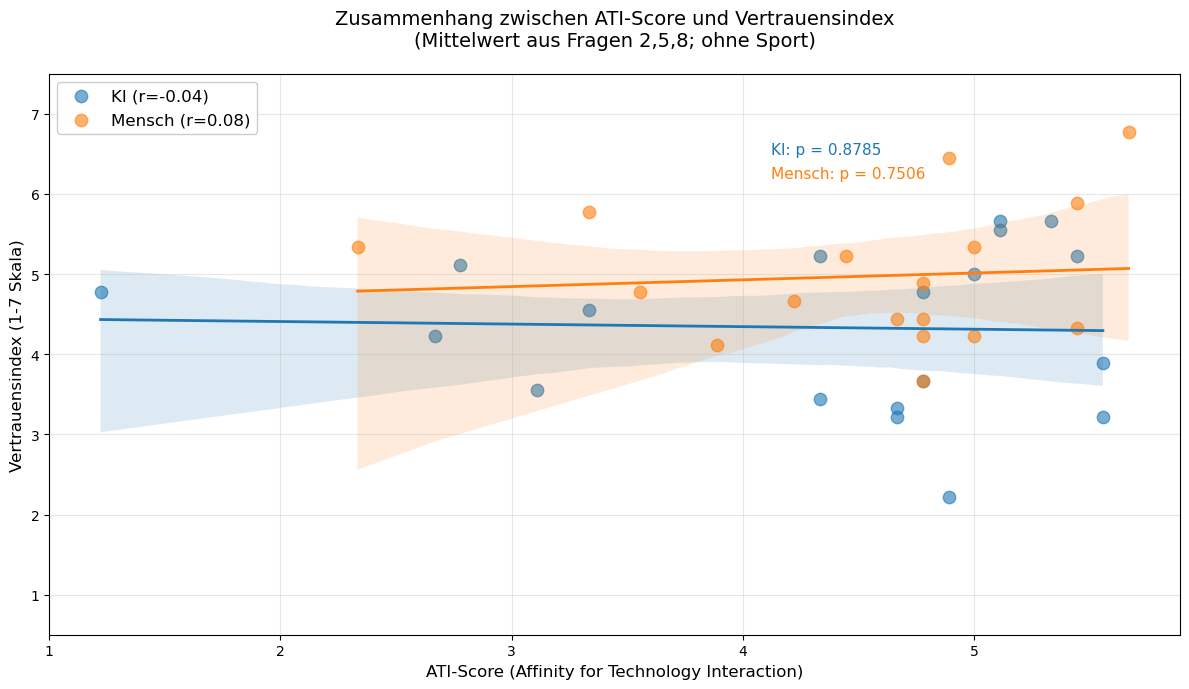

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# Daten laden
ai_data = pd.read_csv('ai_labelled_with_ati.csv')
human_data = pd.read_csv('human_labelled_with_ati.csv')

# Funktion zur Berechnung des Vertrauensindex (Mittelwert aus Fragen 2,5,8)
def calculate_trust_index(row, topic):
    q2 = row[f'{topic} - 2. Wie glaubwürdig fanden Sie den Text ?']
    q5 = row[f'{topic} - 5. Wie viel Vertrauen haben Sie in den Inhalt des Textes?']
    q8 = row[f'{topic} - 8. Wie sehr vertrauen Sie den im Text präsentierten Informationen?']
    return np.mean([q2, q5, q8])

# Vertrauensindex für alle Themen (ohne Sport) berechnen
def add_trust_index(df):
    trust_scores = []
    for _, row in df.iterrows():
        scores = []
        for topic in ['Geld', 'Gesundheit', 'Wissen']:  # Sport weglassen
            scores.append(calculate_trust_index(row, topic))
        trust_scores.append(np.mean(scores))
    df['Vertrauensindex'] = trust_scores
    return df

# Vertrauensindex hinzufügen
ai_data = add_trust_index(ai_data)
human_data = add_trust_index(human_data)

# Deskriptive Statistiken
print("Durchschnittlicher Vertrauensindex (AI):", ai_data['Vertrauensindex'].mean())
print("Durchschnittlicher Vertrauensindex (Mensch):", human_data['Vertrauensindex'].mean())

# Korrelationen berechnen
ai_r, ai_p = stats.pearsonr(ai_data['ATI_Score'], ai_data['Vertrauensindex'])
human_r, human_p = stats.pearsonr(human_data['ATI_Score'], human_data['Vertrauensindex'])

# Ergebnisse
print("\nKorrelationsergebnisse:")
print(f"AI: r = {ai_r:.3f}, p = {ai_p:.4f}")
print(f"Mensch: r = {human_r:.3f}, p = {human_p:.4f}")

# Visualisierung
plt.figure(figsize=(12, 7))

# KI-Daten (blau)
sns.regplot(x='ATI_Score', y='Vertrauensindex', data=ai_data,
            scatter_kws={'color':'#1f77b4', 'alpha':0.6, 's':80},
            line_kws={'color':'#1f77b4', 'lw':2},
            label=f'KI (r={ai_r:.2f}{"***" if ai_p < 0.001 else "**" if ai_p < 0.01 else "*" if ai_p < 0.05 else ""})')

# Mensch-Daten (orange)
sns.regplot(x='ATI_Score', y='Vertrauensindex', data=human_data,
            scatter_kws={'color':'#ff7f0e', 'alpha':0.6, 's':80},
            line_kws={'color':'#ff7f0e', 'lw':2},
            label=f'Mensch (r={human_r:.2f}{"***" if human_p < 0.001 else "**" if human_p < 0.01 else "*" if human_p < 0.05 else ""})')

# Plot-Einstellungen
plt.title('Zusammenhang zwischen ATI-Score und Vertrauensindex\n(Mittelwert aus Fragen 2,5,8; ohne Sport)', pad=20, fontsize=14)
plt.xlabel('ATI-Score (Affinity for Technology Interaction)', fontsize=12)
plt.ylabel('Vertrauensindex (1-7 Skala)', fontsize=12)
plt.ylim(0.5, 7.5)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12, framealpha=1)

# Signifikanzsterne hinzufügen
x_pos = plt.xlim()[1] * 0.7
plt.text(x_pos, 6.5, f"KI: p = {ai_p:.4f}", color='#1f77b4', fontsize=11)
plt.text(x_pos, 6.2, f"Mensch: p = {human_p:.4f}", color='#ff7f0e', fontsize=11)

plt.tight_layout()
plt.show()

Deskriptive Statistiken:

       Themen_Einfluss                                               \
                 count      mean       std  min  25%  50%  75%  max   
Autor                                                                 
KI                19.0  4.736842  1.367971  2.0  4.5  5.0  5.5  7.0   
Mensch            17.0  5.411765  1.371989  2.0  5.0  6.0  6.0  7.0   

       Autor_Einfluss                                               
                count      mean       std  min  25%  50%  75%  max  
Autor                                                               
KI               19.0  4.526316  1.866917  1.0  3.0  5.0  6.0  7.0  
Mensch           17.0  2.588235  1.970369  1.0  1.0  2.0  3.0  6.0  

Korrelationen mit ATI-Score:

KI-Autoren:
Themen-Einfluss: r = -0.153, p = 0.5305
Autor-Einfluss: r = 0.407, p = 0.0840

Mensch-Autoren:
Themen-Einfluss: r = 0.159, p = 0.5423
Autor-Einfluss: r = -0.003, p = 0.9918


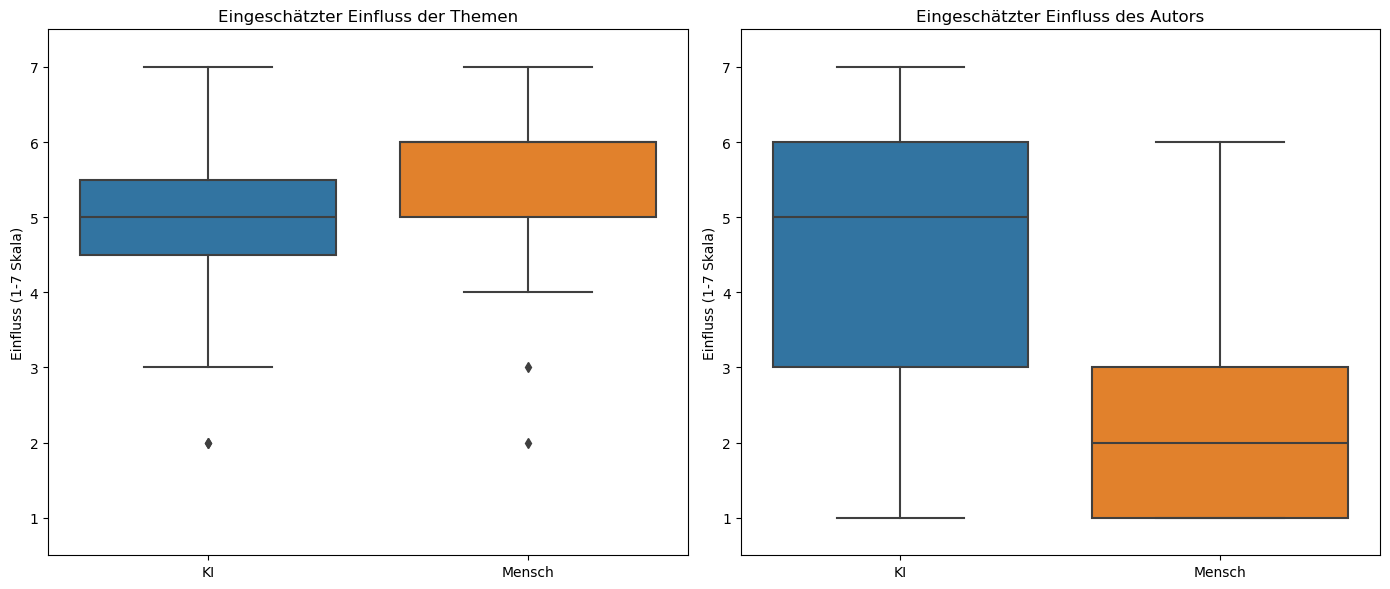

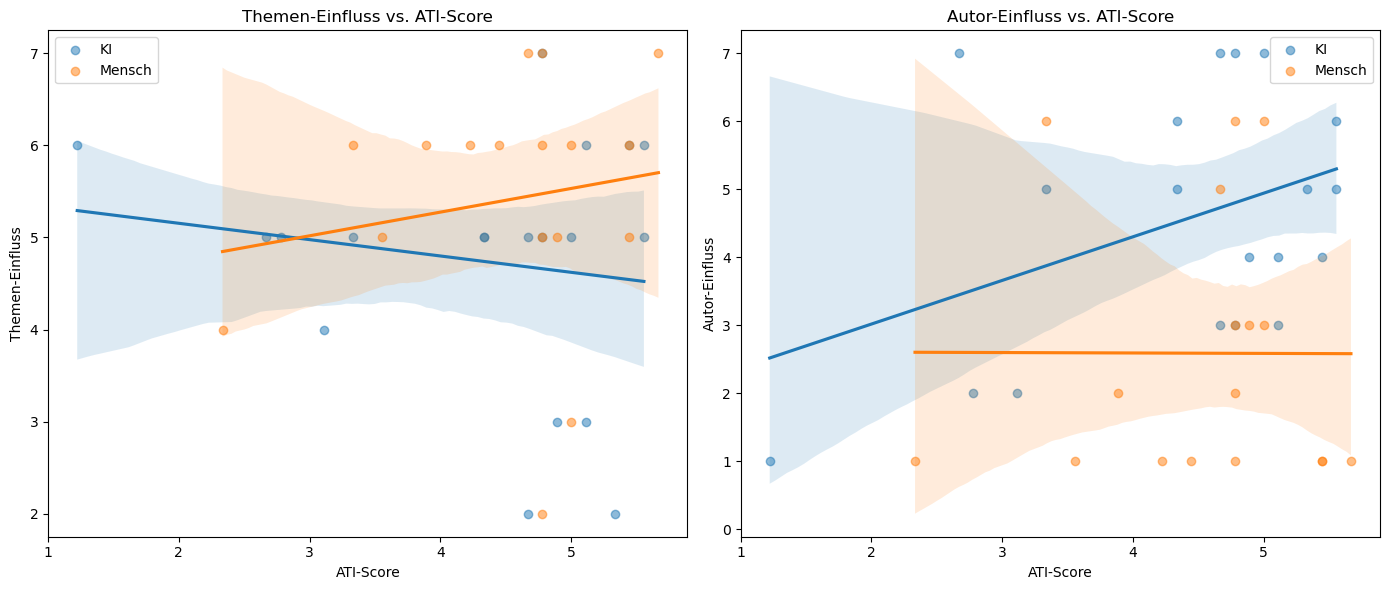

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Daten laden
ai_data = pd.read_csv('ai_labelled_with_ati.csv')
human_data = pd.read_csv('human_labelled_with_ati.csv')

# Daten kombinieren und Autor-Label hinzufügen
ai_data['Autor'] = 'KI'
human_data['Autor'] = 'Mensch'
data = pd.concat([ai_data, human_data])

# Relevante Variablen extrahieren
analysis_data = data[['ATI_Score',
                     'Wie sehr glauben Sie, haben die unterschiedlichen Themen der Texte (Geld, Gesundheit, Sport & Wissen) Ihre Bewertungen beeinflusst?',
                     'Wie sehr glauben Sie, hat das Autor-Label Ihre Bewertungen der Texte beeinflusst?',
                     'Autor']]

# Umbenennen für bessere Lesbarkeit
analysis_data = analysis_data.rename(columns={
    'Wie sehr glauben Sie, haben die unterschiedlichen Themen der Texte (Geld, Gesundheit, Sport & Wissen) Ihre Bewertungen beeinflusst?': 'Themen_Einfluss',
    'Wie sehr glauben Sie, hat das Autor-Label Ihre Bewertungen der Texte beeinflusst?': 'Autor_Einfluss'
})

# Deskriptive Statistiken
print("Deskriptive Statistiken:\n")
print(analysis_data.groupby('Autor')[['Themen_Einfluss', 'Autor_Einfluss']].describe())

# Korrelationsanalyse
print("\nKorrelationen mit ATI-Score:")
for autor in ['KI', 'Mensch']:
    subset = analysis_data[analysis_data['Autor'] == autor]
    corr_theme, p_theme = stats.pearsonr(subset['ATI_Score'], subset['Themen_Einfluss'])
    corr_author, p_author = stats.pearsonr(subset['ATI_Score'], subset['Autor_Einfluss'])
    
    print(f"\n{autor}-Autoren:")
    print(f"Themen-Einfluss: r = {corr_theme:.3f}, p = {p_theme:.4f}")
    print(f"Autor-Einfluss: r = {corr_author:.3f}, p = {p_author:.4f}")

# Visualisierung
plt.figure(figsize=(14, 6))

# Themen-Einfluss
plt.subplot(1, 2, 1)
sns.boxplot(x='Autor', y='Themen_Einfluss', data=analysis_data, 
            palette={'KI': '#1f77b4', 'Mensch': '#ff7f0e'})
plt.title('Eingeschätzter Einfluss der Themen')
plt.xlabel('')
plt.ylabel('Einfluss (1-7 Skala)')
plt.ylim(0.5, 7.5)

# Autor-Einfluss
plt.subplot(1, 2, 2)
sns.boxplot(x='Autor', y='Autor_Einfluss', data=analysis_data,
            palette={'KI': '#1f77b4', 'Mensch': '#ff7f0e'})
plt.title('Eingeschätzter Einfluss des Autors')
plt.xlabel('')
plt.ylabel('Einfluss (1-7 Skala)')
plt.ylim(0.5, 7.5)

plt.tight_layout()
plt.show()

# Scatterplots mit ATI-Score
plt.figure(figsize=(14, 6))

# Themen-Einfluss vs ATI
plt.subplot(1, 2, 1)
sns.regplot(x='ATI_Score', y='Themen_Einfluss', data=analysis_data[analysis_data['Autor'] == 'KI'],
            scatter_kws={'color': '#1f77b4', 'alpha': 0.5}, label='KI')
sns.regplot(x='ATI_Score', y='Themen_Einfluss', data=analysis_data[analysis_data['Autor'] == 'Mensch'],
            scatter_kws={'color': '#ff7f0e', 'alpha': 0.5}, label='Mensch')
plt.title('Themen-Einfluss vs. ATI-Score')
plt.xlabel('ATI-Score')
plt.ylabel('Themen-Einfluss')
plt.legend()

# Autor-Einfluss vs ATI
plt.subplot(1, 2, 2)
sns.regplot(x='ATI_Score', y='Autor_Einfluss', data=analysis_data[analysis_data['Autor'] == 'KI'],
            scatter_kws={'color': '#1f77b4', 'alpha': 0.5}, label='KI')
sns.regplot(x='ATI_Score', y='Autor_Einfluss', data=analysis_data[analysis_data['Autor'] == 'Mensch'],
            scatter_kws={'color': '#ff7f0e', 'alpha': 0.5}, label='Mensch')
plt.title('Autor-Einfluss vs. ATI-Score')
plt.xlabel('ATI-Score')
plt.ylabel('Autor-Einfluss')
plt.legend()

plt.tight_layout()
plt.show()

Durchschnittliche Glaubwürdigkeit (AI): 4.7061403508771935
Durchschnittliche Glaubwürdigkeit (Mensch): 5.102941176470588

Statistische Signifikanz:
AI: r = 0.459, p = 0.0480
Mensch: r = 0.375, p = 0.1385

Interpretation:
AI-Korrelation: * (p < 0.05)
Mensch-Korrelation: n.s. (nicht signifikant)


/var/folders/fg/mnsxwcgd44d0d911s38ny_f80000gn/T/ipykernel_79810/1041304432.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ai_glaubwuerdigkeit['Durchschnitt'] = ai_glaubwuerdigkeit.mean(axis=1)
/var/folders/fg/mnsxwcgd44d0d911s38ny_f80000gn/T/ipykernel_79810/1041304432.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  human_glaubwuerdigkeit['Durchschnitt'] = human_glaubwuerdigkeit.mean(axis=1)


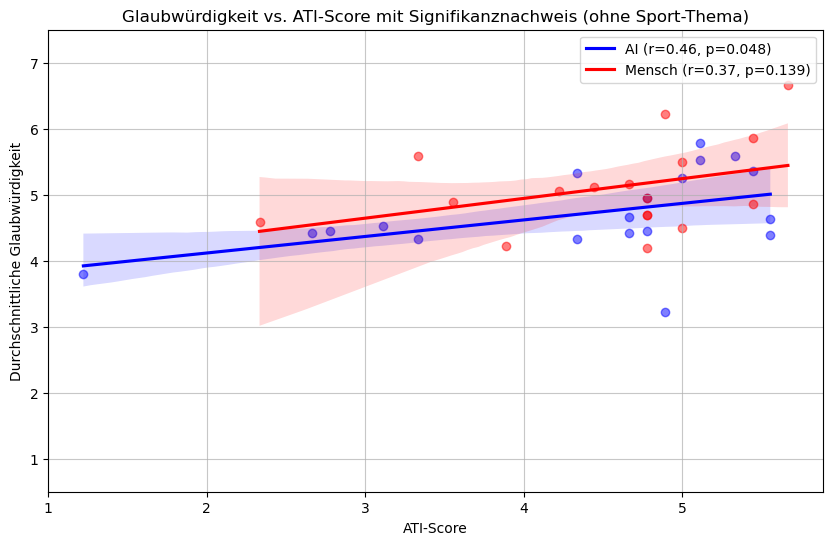

In [23]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Daten laden
ai_data = pd.read_csv('ai_labelled_with_ati.csv')
human_data = pd.read_csv('human_labelled_with_ati.csv')

# Relevante Spalten extrahieren
ai_glaubwuerdigkeit = ai_data[['Geld - 2. Wie glaubwürdig fanden Sie den Text ?', 
                               'Gesundheit - 2. Wie glaubwürdig fanden Sie den Text ?', 
                               'Wissen - 2. Wie glaubwürdig fanden Sie den Text ?', 
                               'ATI_Score']]

human_glaubwuerdigkeit = human_data[['Geld - 2. Wie glaubwürdig fanden Sie den Text ?', 
                                     'Gesundheit - 2. Wie glaubwürdig fanden Sie den Text ?', 
                                     'Wissen - 2. Wie glaubwürdig fanden Sie den Text ?', 
                                     'ATI_Score']]

# Durchschnittliche Glaubwürdigkeit berechnen
ai_glaubwuerdigkeit['Durchschnitt'] = ai_glaubwuerdigkeit.mean(axis=1)
human_glaubwuerdigkeit['Durchschnitt'] = human_glaubwuerdigkeit.mean(axis=1)

# Vergleich der durchschnittlichen Glaubwürdigkeit
print("Durchschnittliche Glaubwürdigkeit (AI):", ai_glaubwuerdigkeit['Durchschnitt'].mean())
print("Durchschnittliche Glaubwürdigkeit (Mensch):", human_glaubwuerdigkeit['Durchschnitt'].mean())



# Korrelationen berechnen
ai_korrelation = ai_glaubwuerdigkeit['Durchschnitt'].corr(ai_glaubwuerdigkeit['ATI_Score'])
human_korrelation = human_glaubwuerdigkeit['Durchschnitt'].corr(human_glaubwuerdigkeit['ATI_Score'])

# Funktion für Korrelationstest mit p-Wert
def correlation_test(x, y):
    r, p = stats.pearsonr(x, y)
    return r, p

# Signifikanztests für beide Gruppen
ai_r, ai_p = correlation_test(ai_glaubwuerdigkeit['ATI_Score'], 
                             ai_glaubwuerdigkeit['Durchschnitt'])
human_r, human_p = correlation_test(human_glaubwuerdigkeit['ATI_Score'], 
                                   human_glaubwuerdigkeit['Durchschnitt'])

# Ergebnisse ausgeben
print("\nStatistische Signifikanz:")
print(f"AI: r = {ai_r:.3f}, p = {ai_p:.4f}")
print(f"Mensch: r = {human_r:.3f}, p = {human_p:.4f}")

# Interpretation hinzufügen
def interpret_p_value(p):
    if p < 0.001:
        return "*** (p < 0.001)"
    elif p < 0.01:
        return "** (p < 0.01)"
    elif p < 0.05:
        return "* (p < 0.05)"
    else:
        return "n.s. (nicht signifikant)"

print("\nInterpretation:")
print(f"AI-Korrelation: {interpret_p_value(ai_p)}")
print(f"Mensch-Korrelation: {interpret_p_value(human_p)}")

# Signifikanz im Plot annotieren
plt.figure(figsize=(10, 6))

# AI-Daten
sns.regplot(x='ATI_Score', y='Durchschnitt', data=ai_glaubwuerdigkeit, 
            scatter_kws={'color': 'blue', 'alpha': 0.5}, 
            line_kws={'color': 'blue', 'label': f'AI (r={ai_r:.2f}, p={ai_p:.3f})'})

# Mensch-Daten
sns.regplot(x='ATI_Score', y='Durchschnitt', data=human_glaubwuerdigkeit, 
            scatter_kws={'color': 'red', 'alpha': 0.5}, 
            line_kws={'color': 'red', 'label': f'Mensch (r={human_r:.2f}, p={human_p:.3f})'})

plt.ylim(0.5, 7.5)
plt.grid(axis='both', alpha=0.7)
plt.xlabel('ATI-Score')
plt.ylabel('Durchschnittliche Glaubwürdigkeit')
plt.title('Glaubwürdigkeit vs. ATI-Score mit Signifikanznachweis (ohne Sport-Thema)')
plt.legend()
plt.show()


--- Frage 1: Vorwissen ---
Deskriptive Statistiken:
            count      mean       std  min  25%  50%  75%  max
Thema                                                         
Geld         36.0  3.777778  1.972831  1.0  2.0  4.5  5.0  7.0
Gesundheit   36.0  3.138889  1.476536  1.0  2.0  3.0  4.0  7.0
Wissen       36.0  2.972222  1.731822  1.0  2.0  3.0  4.0  7.0

ANOVA: F = 2.15, p = 0.1213


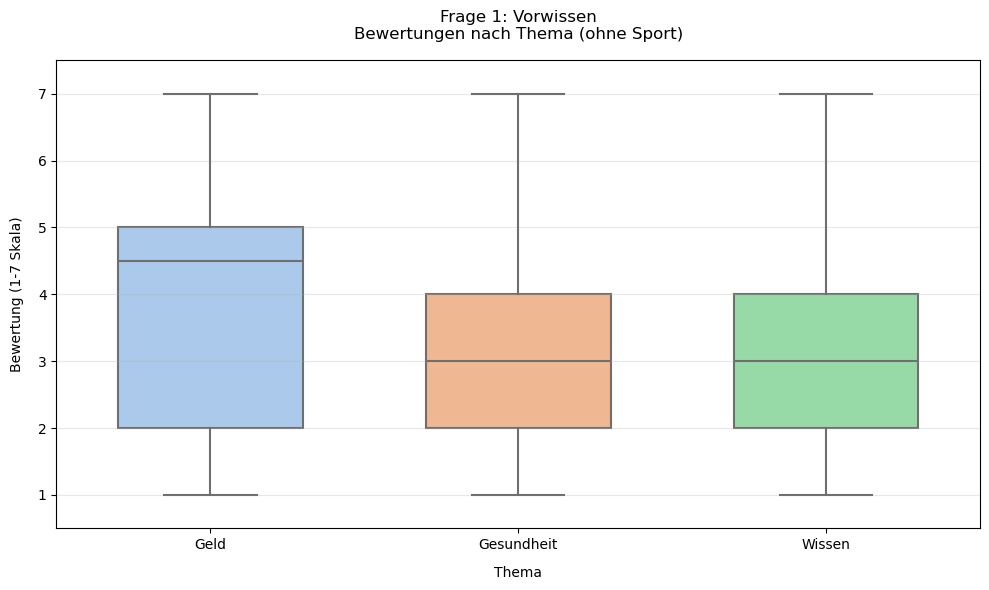


--- Frage 2: Glaubwürdigkeit ---
Deskriptive Statistiken:
            count      mean       std  min  25%  50%  75%  max
Thema                                                         
Geld         36.0  5.138889  1.198875  3.0  4.0  5.0  6.0  7.0
Gesundheit   36.0  5.388889  1.128280  2.0  5.0  5.5  6.0  7.0
Wissen       36.0  4.611111  1.358103  2.0  4.0  5.0  5.0  7.0

ANOVA: F = 3.74, p = 0.0270

Post-hoc Tukey HSD Tests:
    Multiple Comparison of Means - Tukey HSD, FWER=0.05     
  group1     group2   meandiff p-adj   lower   upper  reject
------------------------------------------------------------
      Geld Gesundheit     0.25 0.6661 -0.4405  0.9405  False
      Geld     Wissen  -0.5278 0.1689 -1.2182  0.1627  False
Gesundheit     Wissen  -0.7778 0.0232 -1.4682 -0.0873   True
------------------------------------------------------------


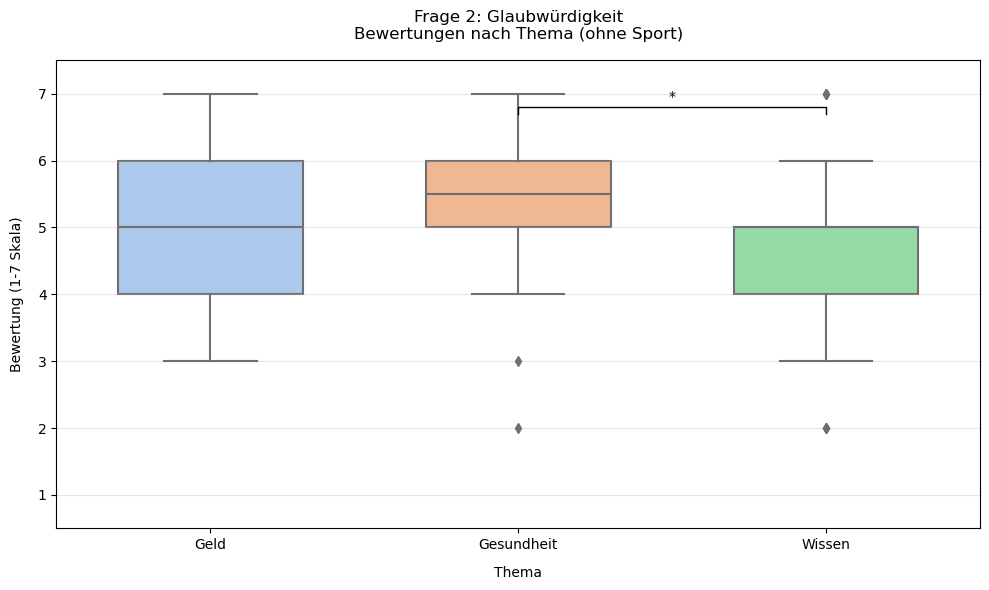


--- Frage 3: Verständlichkeit ---
Deskriptive Statistiken:
            count      mean       std  min  25%  50%  75%  max
Thema                                                         
Geld         36.0  4.805556  1.564233  1.0  4.0  5.0  6.0  7.0
Gesundheit   36.0  5.972222  1.081959  2.0  6.0  6.0  7.0  7.0
Wissen       36.0  5.083333  1.155731  3.0  4.0  5.0  6.0  7.0

ANOVA: F = 8.10, p = 0.0005

Post-hoc Tukey HSD Tests:
    Multiple Comparison of Means - Tukey HSD, FWER=0.05     
  group1     group2   meandiff p-adj   lower   upper  reject
------------------------------------------------------------
      Geld Gesundheit   1.1667 0.0006  0.4466  1.8867   True
      Geld     Wissen   0.2778 0.6307 -0.4422  0.9978  False
Gesundheit     Wissen  -0.8889 0.0113 -1.6089 -0.1689   True
------------------------------------------------------------


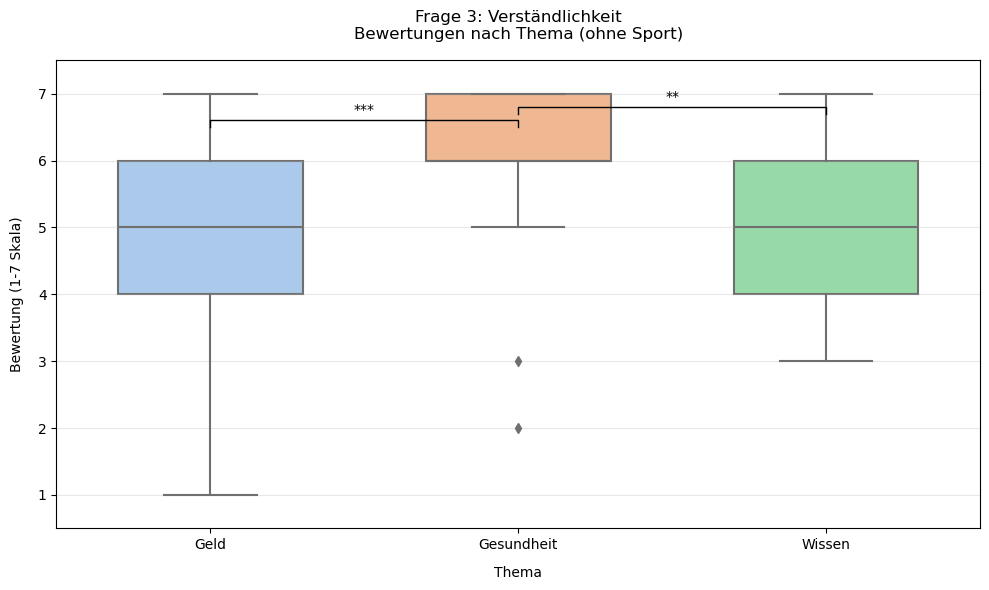


--- Frage 4: Interessantheit ---
Deskriptive Statistiken:
            count      mean       std  min  25%  50%  75%  max
Thema                                                         
Geld         36.0  4.361111  1.838521  1.0  2.0  5.0  6.0  7.0
Gesundheit   36.0  4.972222  1.463579  1.0  4.0  5.0  6.0  7.0
Wissen       36.0  4.444444  1.611467  1.0  3.0  4.5  6.0  7.0

ANOVA: F = 1.46, p = 0.2367


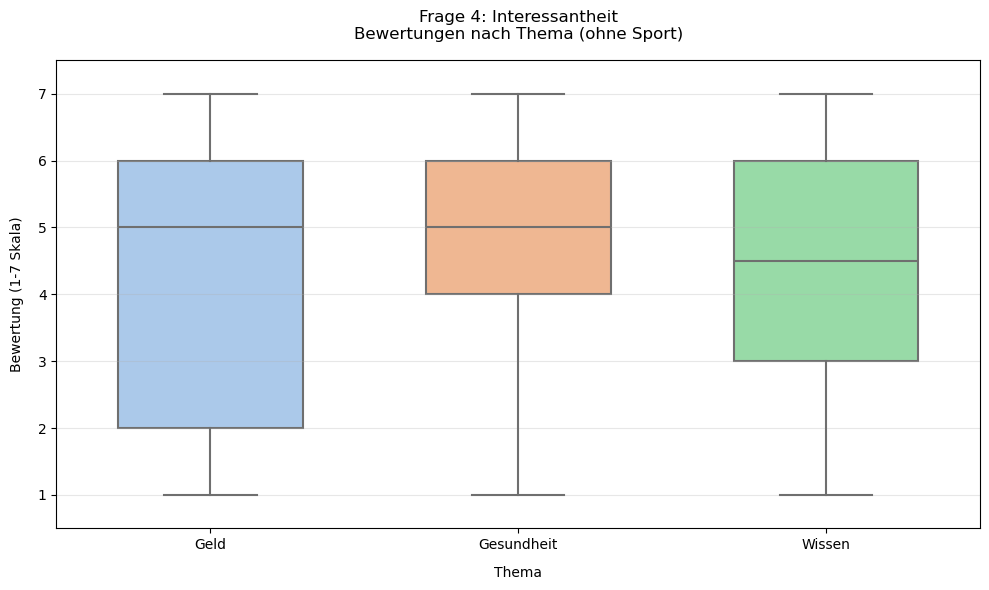


--- Frage 5: Vertrauen ---
Deskriptive Statistiken:
            count      mean       std  min  25%  50%  75%  max
Thema                                                         
Geld         36.0  4.583333  1.537623  2.0  3.0  5.0  6.0  7.0
Gesundheit   36.0  4.750000  1.360147  2.0  4.0  5.0  6.0  7.0
Wissen       36.0  4.000000  1.454058  1.0  3.0  4.0  5.0  7.0

ANOVA: F = 2.65, p = 0.0756


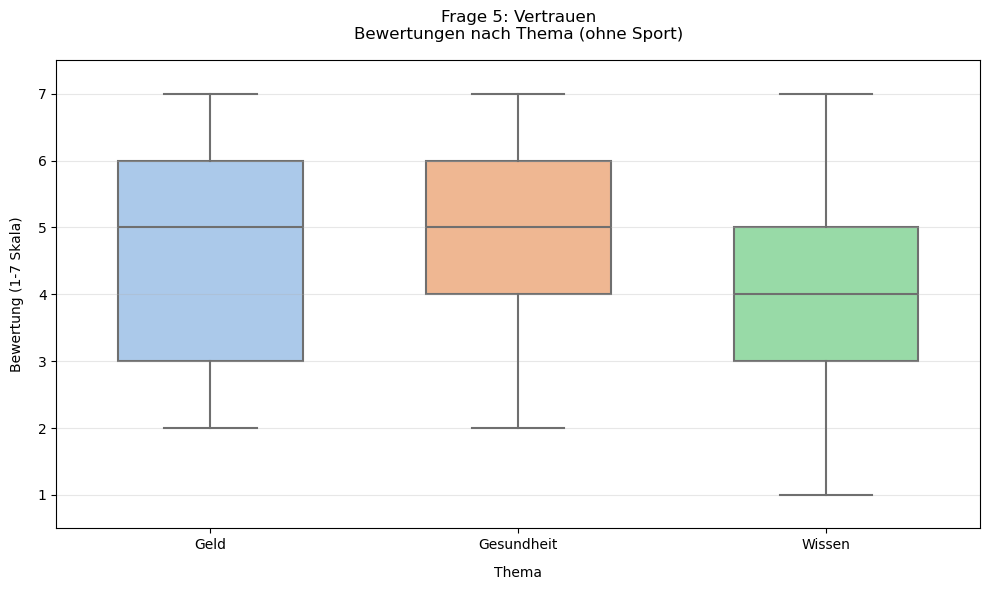


--- Frage 6: Sachlichkeit ---
Deskriptive Statistiken:
            count      mean       std  min  25%  50%   75%  max
Thema                                                          
Geld         36.0  5.416667  1.227657  2.0  5.0  6.0  6.00  7.0
Gesundheit   36.0  5.555556  0.939436  3.0  5.0  6.0  6.00  7.0
Wissen       36.0  4.055556  1.722862  1.0  3.0  4.0  5.25  7.0

ANOVA: F = 13.85, p = 0.0000

Post-hoc Tukey HSD Tests:
    Multiple Comparison of Means - Tukey HSD, FWER=0.05     
  group1     group2   meandiff p-adj   lower   upper  reject
------------------------------------------------------------
      Geld Gesundheit   0.1389 0.8985   -0.61  0.8878  False
      Geld     Wissen  -1.3611 0.0001   -2.11 -0.6122   True
Gesundheit     Wissen     -1.5    0.0 -2.2489 -0.7511   True
------------------------------------------------------------


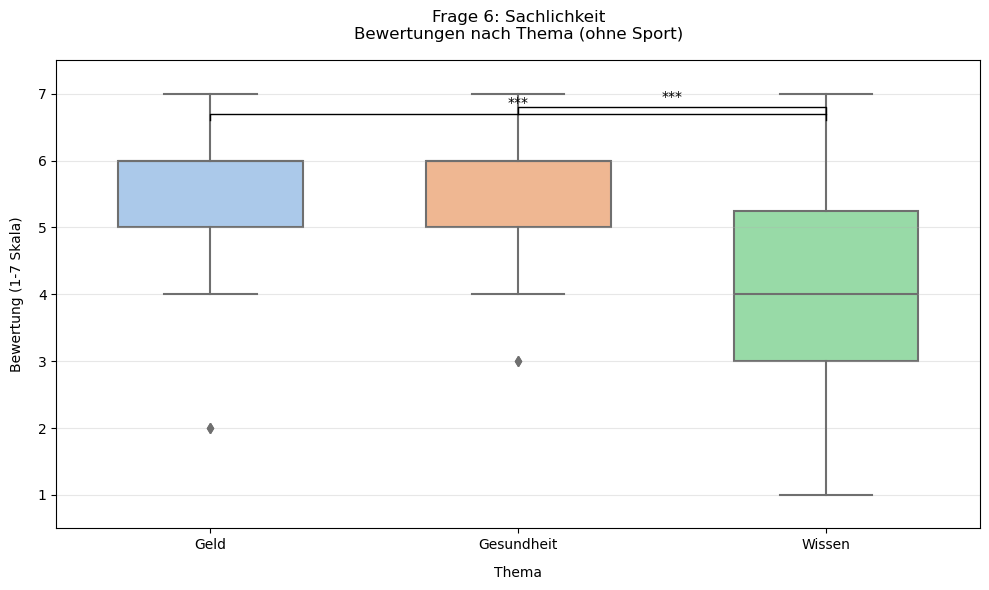


--- Frage 7: Fachkompetenz ---
Deskriptive Statistiken:
            count      mean       std  min   25%  50%  75%  max
Thema                                                          
Geld         36.0  5.055556  1.193900  2.0  4.75  5.0  6.0  7.0
Gesundheit   36.0  5.250000  1.079021  2.0  5.00  5.0  6.0  7.0
Wissen       36.0  4.194444  1.237958  1.0  4.00  4.0  5.0  7.0

ANOVA: F = 8.27, p = 0.0005

Post-hoc Tukey HSD Tests:
    Multiple Comparison of Means - Tukey HSD, FWER=0.05     
  group1     group2   meandiff p-adj   lower   upper  reject
------------------------------------------------------------
      Geld Gesundheit   0.1944 0.7618 -0.4624  0.8513  False
      Geld     Wissen  -0.8611 0.0066  -1.518 -0.2043   True
Gesundheit     Wissen  -1.0556 0.0007 -1.7124 -0.3987   True
------------------------------------------------------------


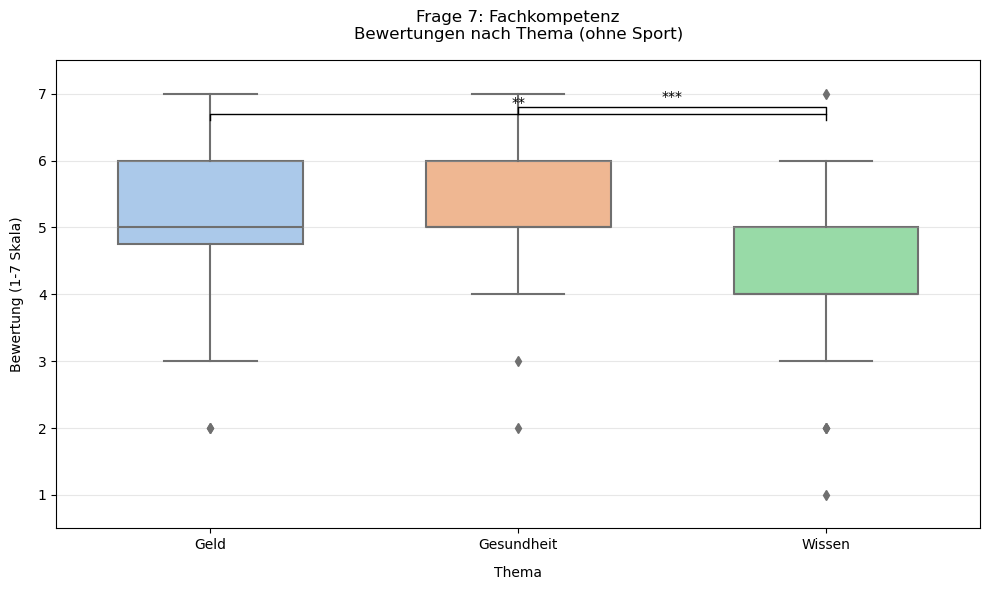


--- Frage 8: Vertrauen in Informationen ---
Deskriptive Statistiken:
            count      mean       std  min  25%  50%  75%  max
Thema                                                         
Geld         36.0  4.666667  1.414214  2.0  4.0  5.0  6.0  7.0
Gesundheit   36.0  4.833333  1.383577  1.0  4.0  5.0  6.0  7.0
Wissen       36.0  3.750000  1.556094  1.0  3.0  3.0  5.0  7.0

ANOVA: F = 5.80, p = 0.0041

Post-hoc Tukey HSD Tests:
    Multiple Comparison of Means - Tukey HSD, FWER=0.05     
  group1     group2   meandiff p-adj   lower   upper  reject
------------------------------------------------------------
      Geld Gesundheit   0.1667 0.8778 -0.6477   0.981  False
      Geld     Wissen  -0.9167 0.0233  -1.731 -0.1023   True
Gesundheit     Wissen  -1.0833 0.0058 -1.8977  -0.269   True
------------------------------------------------------------


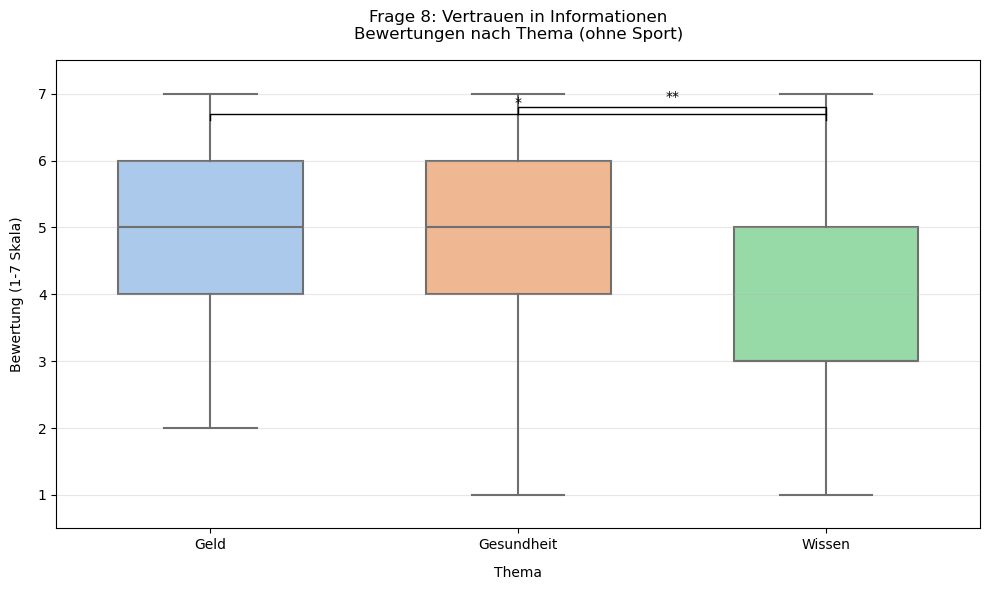


--- Frage 9: Missverständnispotential ---
Deskriptive Statistiken:
            count      mean       std  min  25%  50%  75%  max
Thema                                                         
Geld         36.0  3.083333  1.380993  1.0  2.0  3.0  4.0  7.0
Gesundheit   36.0  2.555556  0.998411  1.0  2.0  2.0  3.0  5.0
Wissen       36.0  3.250000  1.421770  2.0  2.0  3.0  4.0  6.0

ANOVA: F = 2.88, p = 0.0605


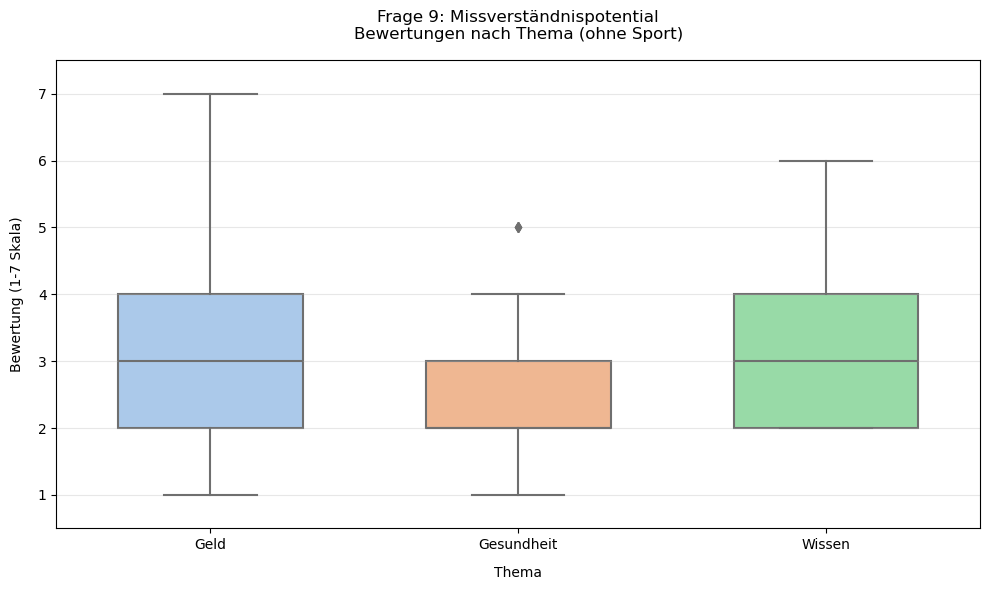

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np

# Daten laden
ai_data = pd.read_csv('ai_labelled_with_ati.csv')
human_data = pd.read_csv('human_labelled_with_ati.csv')
data = pd.concat([ai_data, human_data])

# Fragenkatalog
questions = {
    1: "Vorwissen",
    2: "Glaubwürdigkeit",
    3: "Verständlichkeit",
    4: "Interessantheit",
    5: "Vertrauen",
    6: "Sachlichkeit",
    7: "Fachkompetenz",
    8: "Vertrauen in Informationen",
    9: "Missverständnispotential"
}

# Themen, die analysiert werden sollen (ohne Sport)
themes = ['Geld', 'Gesundheit', 'Wissen']

def analyze_questions_separately():
    for q_num, q_name in questions.items():
        # Daten für diese Frage extrahieren
        q_data = pd.DataFrame()
        for theme in themes:
            # Finde die passende Spalte für diese Frage und Thema
            col_pattern = f"{theme} - {q_num}."
            matching_cols = [col for col in data.columns if col.startswith(col_pattern)]
            if matching_cols:
                q_data[theme] = data[matching_cols[0]]
        
        # Daten für Visualisierung vorbereiten
        melted_data = pd.melt(q_data, 
                            value_vars=themes,
                            var_name='Thema', 
                            value_name='Bewertung')
        
        # Boxplot erstellen
        plt.figure(figsize=(10, 6))
        sns.boxplot(x='Thema', y='Bewertung', 
                   data=melted_data, 
                   palette='pastel', 
                   width=0.6,
                   order=themes)
        
        plt.title(f'Frage {q_num}: {q_name}\nBewertungen nach Thema (ohne Sport)', pad=15)
        plt.xlabel('Thema', labelpad=10)
        plt.ylabel('Bewertung (1-7 Skala)', labelpad=10)
        plt.ylim(0.5, 7.5)
        
        # ANOVA durchführen
        groups = [melted_data[melted_data['Thema'] == t]['Bewertung'] 
                 for t in themes]
        
        # Deskriptive Statistiken ausgeben
        print(f"\n--- Frage {q_num}: {q_name} ---")
        print("Deskriptive Statistiken:")
        print(melted_data.groupby('Thema')['Bewertung'].describe())
        
        # ANOVA nur durchführen wenn genug Daten vorhanden sind
        if all(len(g) > 1 for g in groups):
            f_stat, p_val = stats.f_oneway(*groups)
            print(f"\nANOVA: F = {f_stat:.2f}, p = {p_val:.4f}")
            
            # Signifikanzmarkierungen im Plot
            if p_val < 0.05:
                from statsmodels.stats.multicomp import pairwise_tukeyhsd
                print("\nPost-hoc Tukey HSD Tests:")
                tukey = pairwise_tukeyhsd(melted_data['Bewertung'],
                                        melted_data['Thema'],
                                        alpha=0.05)
                print(tukey)
                
                # Signifikante Unterschiede im Plot markieren
                y_pos = 6.5
                h = 0.1
                
                # Vergleiche zwischen allen Themenpaaren
                comparisons = [(0,1), (0,2), (1,2)]  # Indizes der Themen in der Liste
                for i, (idx1, idx2) in enumerate(comparisons):
                    group1 = themes[idx1]
                    group2 = themes[idx2]
                    data1 = melted_data[melted_data['Thema'] == group1]['Bewertung']
                    data2 = melted_data[melted_data['Thema'] == group2]['Bewertung']
                    
                    # t-Test zwischen den beiden Gruppen
                    t_stat, p_val_pair = stats.ttest_ind(data1, data2, equal_var=False)
                    
                    if p_val_pair < 0.05:
                        plt.plot([idx1, idx1, idx2, idx2], 
                                [y_pos + i*h, y_pos + i*h + 0.1, y_pos + i*h + 0.1, y_pos + i*h], 
                                lw=1, color='black')
                        if p_val_pair < 0.001:
                            symbol = '***'
                        elif p_val_pair < 0.01:
                            symbol = '**'
                        elif p_val_pair < 0.05:
                            symbol = '*'
                        plt.text((idx1+idx2)*0.5, y_pos + i*h + 0.15, 
                                symbol, ha='center', va='bottom', color='black')
        else:
            print("\nNicht genug Daten für ANOVA")
        
        plt.tight_layout()
        plt.grid(axis='y', alpha=0.3)
        plt.show()

# Analyse durchführen
analyze_questions_separately()

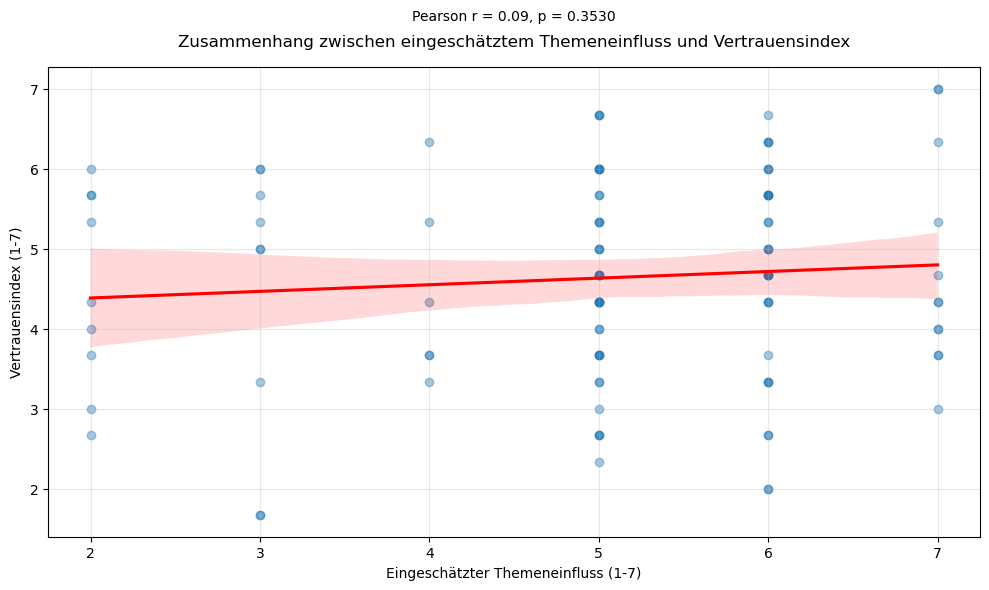


Korrelationen pro Thema:
Geld: r = 0.13, p = 0.4671
Gesundheit: r = 0.13, p = 0.4616
Wissen: r = 0.04, p = 0.8249


In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# Daten vorbereiten (wie zuvor)
ai_data = pd.read_csv('ai_labelled.csv')
human_data = pd.read_csv('human_labelled.csv', sep=';')
data = pd.concat([ai_data, human_data])

# Vertrauensindex berechnen (Fragen 2,5,8)
def calculate_trust_index(row, topic):
    q2 = row[f'{topic} - 2. Wie glaubwürdig fanden Sie den Text ?']
    q5 = row[f'{topic} - 5. Wie viel Vertrauen haben Sie in den Inhalt des Textes?']
    q8 = row[f'{topic} - 8. Wie sehr vertrauen Sie den im Text präsentierten Informationen?']
    return np.mean([q2, q5, q8])

# Datenstruktur erstellen
analysis_data = []
for topic in ['Geld', 'Gesundheit', 'Wissen']:
    temp_df = data[['Wie sehr glauben Sie, haben die unterschiedlichen Themen der Texte (Geld, Gesundheit, Sport & Wissen) Ihre Bewertungen beeinflusst?']].copy()
    temp_df['Thema'] = topic
    temp_df['Vertrauensindex'] = data.apply(lambda row: calculate_trust_index(row, topic), axis=1)
    temp_df = temp_df.rename(columns={
        'Wie sehr glauben Sie, haben die unterschiedlichen Themen der Texte (Geld, Gesundheit, Sport & Wissen) Ihre Bewertungen beeinflusst?': 'Themen_Einfluss'
    })
    analysis_data.append(temp_df)

analysis_data = pd.concat(analysis_data)

# Scatterplot mit Regression
plt.figure(figsize=(10, 6))
sns.regplot(x='Themen_Einfluss', y='Vertrauensindex', data=analysis_data, 
            scatter_kws={'alpha': 0.4}, line_kws={'color': 'red'})
plt.title('Zusammenhang zwischen eingeschätztem Themeneinfluss und Vertrauensindex', pad=15)
plt.xlabel('Eingeschätzter Themeneinfluss (1-7)')
plt.ylabel('Vertrauensindex (1-7)')
plt.grid(alpha=0.3)

# Korrelation berechnen
r, p = stats.pearsonr(analysis_data['Themen_Einfluss'], analysis_data['Vertrauensindex'])
plt.text(0.5, 1.1, f"Pearson r = {r:.2f}, p = {p:.4f}", transform=plt.gca().transAxes, ha='center')

plt.tight_layout()
plt.show()

# Getrennte Analyse pro Thema
print("\nKorrelationen pro Thema:")
for topic in ['Geld', 'Gesundheit', 'Wissen']:
    subset = analysis_data[analysis_data['Thema'] == topic]
    r, p = stats.pearsonr(subset['Themen_Einfluss'], subset['Vertrauensindex'])
    print(f"{topic}: r = {r:.2f}, p = {p:.4f}")